In [1]:
#hide
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from IPython.display import display,HTML

# NLP Deep Dive: RNNs
    What we call a language model is a model that has been trained to guess what the next word in a text is (having read the ones before). This kind of task is called self-supervised learning: we do not need to give labels to our model, just feed it lots and lots of texts. It has a process to automatically get labels from the data, and this task isn't trivial: to properly guess the next word in a sentence, the model will have to develop an understanding of the English (or other) language. 
       Self-supervised learning is not usually used for the model that is trained directly, but instead is used for pretraining a model used for transfer learning. 
        

jargon: Self-supervised learning: Training a model using labels that are embedded in the independent variable, rather than requiring external labels. For instance, training a model to predict the next word in a text.

# Text Preprocessing
It's not at all obvious how we're going to use what we've learned so far to build a language model. Sentences can be different lengths, and documents can be very long. So, how can we predict the next word of a sentence using a neural network? Let's find out!

We've already seen how categorical variables can be used as independent variables for a neural network. The approach we took for a single categorical variable was to:

1. Make a list of all possible levels of that categorical variable (we'll call this list the vocab).
2. Replace each level with its index in the vocab.
3. Create an embedding matrix for this containing a row for each level (i.e., for each item of the vocab).
4. Use this embedding matrix as the first layer of a neural network. (A dedicated embedding matrix can take as inputs the raw vocab indexes created in step 2; this is equivalent to but faster and more efficient than a matrix that takes as input one-hot-encoded vectors representing the indexes.)

We can do nearly the same thing with text! What is new is the idea of a sequence. First we concatenate all of the documents in our dataset into one big long string and split it into words, giving us a very long list of words (or "tokens"). Our independent variable will be the sequence of words starting with the first word in our very long list and ending with the second to last, and our dependent variable will be the sequence of words starting with the second word and ending with the last word.

Each of the steps necessary to create a language model has jargon associated with it from the world of natural language processing, and fastai and PyTorch classes available to help. The steps are:

1. Tokenization:: Convert the text into a list of words (or characters, or substrings, depending on the granularity of your model)
2. Numericalization:: Make a list of all of the unique words that appear (the vocab), and convert each word into a number, by looking up its index in the vocab
3. Language model data loader creation:: fastai provides an LMDataLoader class which automatically handles creating a dependent variable that is offset from the independent variable by one token. It also handles some important details, such as how to shuffle the training data in such a way that the dependent and independent variables maintain their structure as required
4. Language model creation:: We need a special kind of model that does something we haven't seen before: handles input lists which could be arbitrarily big or small. There are a number of ways to do this; in this chapter we will be using a recurrent neural network (RNN).

# Tokenization
When we said "convert the text into a list of words," we left out a lot of details. For instance, what do we do with punctuation? How do we deal with a word like "don't"? Is it one word, or two? What about long medical or chemical words? Should they be split into their separate pieces of meaning? How about hyphenated words? What about languages like German and Polish where we can create really long words from many, many pieces? What about languages like Japanese and Chinese that don't use bases at all, and don't really have a well-defined idea of word?

Because there is no one correct answer to these questions, there is no one approach to tokenization. There are three main approaches:

Word-based:: Split a sentence on spaces, as well as applying language-specific rules to try to separate parts of meaning even when there are no spaces (such as turning "don't" into "do n't"). Generally, punctuation marks are also split into separate tokens.
Subword based:: Split words into smaller parts, based on the most commonly occurring substrings. For instance, "occasion" might be tokenized as "o c ca sion."
Character-based:: Split a sentence into its individual characters.

jargon: token: One element of a list created by the tokenization process. It could be a word, part of a word (a subword), or a single character.

Word Tokenization with fastai
Rather than providing its own tokenizers, fastai instead provides a consistent interface to a range of tokenizers in external libraries. Tokenization is an active field of research, and new and improved tokenizers are coming out all the time, so the defaults that fastai uses change too. However, the API and options shouldn't change too much, since fastai tries to maintain a consistent API even as the underlying technology changes.

Let's try it out with the IMDb dataset

In [3]:
from fastai.text.all import *
path = untar_data(URLs.IMDB)

C:\Users\Naim Cavin\anaconda3\lib\site-packages\cupy\_environment.py:205: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\Naim Cavin\anaconda3\lib\site-packages\cupy\_environment.py:205: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\Naim Cavin\anaconda3\lib\site-packages\cupy\_environment.py:205: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\Naim Cavin\anaconda3\lib\site-packages\cupy\_environment.py:205: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\Naim Cavin\anaconda3\lib\site-packages\cupy\_environment.py:205: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\Naim Cavin\anaco

In [4]:
files = get_text_files(path, folders = ['train', 'test', 'unsup'])


In [5]:
a=files[7].open().read()
a[:50]

'Being a long-time fan of Japanese film, I expected'

In [6]:
spacy = WordTokenizer()
toks = first(spacy([a]))
print(coll_repr(toks, 30))

(#171) ['Being','a','long','-','time','fan','of','Japanese','film',',','I','expected','more','than','this','.','I','ca',"n't",'really','be','bothered','to','write','to','much',',','as','this','movie'...]


In [7]:
txt = files[0].open().read(); txt[:75]

'Once again Mr. Costner has dragged out a movie for far longer than necessar'

In [8]:
spacy = WordTokenizer()
toks = first(spacy([txt]))
print(coll_repr(toks, 30))

(#187) ['Once','again','Mr.','Costner','has','dragged','out','a','movie','for','far','longer','than','necessary','.','Aside','from','the','terrific','sea','rescue','sequences',',','of','which','there','are','very','few','I'...]


In [9]:
txt

"Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costner's character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks he's better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutcher's ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in."

As you see, spaCy has mainly just separated out the words and punctuation. But it does something else here too: it has split "it's" into "it" and "'s". That makes intuitive sense; these are separate words, really. Tokenization is a surprisingly subtle task, when you think about all the little details that have to be handled. Fortunately, spaCy handles these pretty well for us—for instance, here we see that "." is separated when it terminates a sentence, but not in an acronym or number:

In [10]:
first(spacy(['The U.S. dollar $1 is $1.00.']))

(#9) ['The','U.S.','dollar','$','1','is','$','1.00','.']

fastai then adds some additional functionality to the tokenization process with the Tokenizer class:



In [11]:
tkn = Tokenizer(spacy)
#tkn = Tokenizer(WordTokenizer())
print(coll_repr(tkn(txt), 31))

(#207) ['xxbos','xxmaj','once','again','xxmaj','mr','.','xxmaj','costner','has','dragged','out','a','movie','for','far','longer','than','necessary','.','xxmaj','aside','from','the','terrific','sea','rescue','sequences',',','of','which'...]


Notice that there are now some tokens that start with the characters "xx", which is not a common word prefix in English. These are special tokens.

For example, the first item in the list, xxbos, is a special token that indicates the start of a new text ("BOS" is a standard NLP acronym that means "beginning of stream"). By recognizing this start token, the model will be able to learn it needs to "forget" what was said previously and focus on upcoming words.

These special tokens don't come from spaCy directly. They are there because fastai adds them by default, by applying a number of rules when processing text. These rules are designed to make it easier for a model to recognize the important parts of a sentence. In a sense, we are translating the original English language sequence into a simplified tokenized language—a language that is designed to be easy for a model to learn.

For instance, the rules will replace a sequence of four exclamation points with a special repeated character token, followed by the number four, and then a single exclamation point. In this way, the model's embedding matrix can encode information about general concepts such as repeated punctuation rather than requiring a separate token for every number of repetitions of every punctuation mark. Similarly, a capitalized word will be replaced with a special capitalization token, followed by the lowercase version of the word. This way, the embedding matrix only needs the lowercase versions of the words, saving compute and memory resources, but can still learn the concept of capitalization.

Here are some of the main special tokens you'll see:

xxbos:: Indicates the beginning of a text (here, a review)
xxmaj:: Indicates the next word begins with a capital (since we lowercased everything)
xxunk:: Indicates the word is unknown

To see the rules that were used, you can check the default rules:



In [12]:
defaults.text_proc_rules

[<function fastai.text.core.fix_html(x)>,
 <function fastai.text.core.replace_rep(t)>,
 <function fastai.text.core.replace_wrep(t)>,
 <function fastai.text.core.spec_add_spaces(t)>,
 <function fastai.text.core.rm_useless_spaces(t)>,
 <function fastai.text.core.replace_all_caps(t)>,
 <function fastai.text.core.replace_maj(t)>,
 <function fastai.text.core.lowercase(t, add_bos=True, add_eos=False)>]

Here is a brief summary of what each does:

fix_html:: Replaces special HTML characters with a readable version (IMDb reviews have quite a few of these)

replace_rep:: Replaces any character repeated three times or more with a special token for repetition (xxrep), the number of 
times it's repeated, then the character

replace_wrep:: Replaces any word repeated three times or more with a special token for word repetition (xxwrep), the number of times it's repeated, then the word

spec_add_spaces:: Adds spaces around / and #

rm_useless_spaces:: Removes all repetitions of the space character

replace_all_caps:: Lowercases a word written in all caps and adds a special token for all caps (xxup) in front of it

replace_maj:: Lowercases a capitalized word and adds a special token for capitalized (xxmaj) in front of it

lowercase:: Lowercases all text and adds a special token at the beginning (xxbos) and/or the end (xxeos)

In [13]:
coll_repr(tkn('&copy;   Fast.ai www.fast.ai/INDEX'), 31)


"(#11) ['xxbos','©','xxmaj','fast.ai','xxrep','3','w','.fast.ai','/','xxup','index']"

Let's look at an example. For our corpus, we'll use the first 2,000 movie reviews:



In [14]:
txts = L(o.open(encoding="utf8").read() for o in files[:2000])

Once our texts have been split into tokens, we need to convert them to numbers. We'll look at that next.

# Numericalization with fastai
Numericalization is the process of mapping tokens to integers. The steps are basically identical to those necessary to create a Category variable, such as the dependent variable of digits in MNIST:

1. Make a list of all possible levels of that categorical variable (the vocab).
2. Replace each level with its index in the vocab

In [15]:
toks = tkn(txt)
print(coll_repr(tkn(txt), 31))

(#207) ['xxbos','xxmaj','once','again','xxmaj','mr','.','xxmaj','costner','has','dragged','out','a','movie','for','far','longer','than','necessary','.','xxmaj','aside','from','the','terrific','sea','rescue','sequences',',','of','which'...]


We need to call setup on Numericalize; this is how we create the vocab. That means we'll need our tokenized corpus first. Since tokenization takes a while, it's done in parallel by fastai; but for this manual walkthrough, we'll use a small subset:

In [16]:
toks200 = txts[:200].map(tkn)
toks200[0]

(#207) ['xxbos','xxmaj','once','again','xxmaj','mr','.','xxmaj','costner','has'...]

We can pass this to setup to create our vocab:



In [17]:
num = Numericalize()
num.setup(toks200)
coll_repr(num.vocab,20)

"(#1968) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the','.',',','a','and','of','to','is','it','i','in'...]"

Our special rules tokens appear first, and then every word appears once, in frequency order. The defaults to Numericalize are min_freq=3,max_vocab=60000. max_vocab=60000 results in fastai replacing all words other than the most common 60,000 with a special unknown word token, xxunk. This is useful to avoid having an overly large embedding matrix, since that can slow down training and use up too much memory, and can also mean that there isn't enough data to train useful representations for rare words. However, this last issue is better handled by setting min_freq; the default min_freq=3 means that any word appearing less than three times is replaced with xxunk.

fastai can also numericalize your dataset using a vocab that you provide, by passing a list of words as the vocab parameter.

Once we've created our Numericalize object, we can use it as if it were a function:

In [18]:
nums = num(toks)[:20]; nums

TensorText([   2,    8,  349,  183,    8, 1176,   10,    8, 1177,   60, 1455,   62,   12,   25,   28,  189,  957,   93,  958,   10])

This time, our tokens have been converted to a tensor of integers that our model can receive. We can check that they map back to the original text:



In [19]:
' '.join(num.vocab[o] for o in nums)

'xxbos xxmaj once again xxmaj mr . xxmaj costner has dragged out a movie for far longer than necessary .'

Now that we have numbers, we need to put them in batches for our model.



We now have 90 tokens, separated by spaces. Let's say we want a batch size of 6. We need to break this text into 6 contiguous parts of length 15:

In [20]:
stream = "In this chapter, we will go back over the example of classifying movie reviews we studied in chapter 1 and dig deeper under the surface. First we will look at the processing steps necessary to convert text into numbers and how to customize it. By doing this, we'll have another example of the PreProcessor used in the data block API.\nThen we will study how we build a language model and train it for a while."
tokens = tkn(stream)
bs,seq_len = 6,15
d_tokens = np.array([tokens[i*seq_len:(i+1)*seq_len] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False,header=None)))

xxbos,xxmaj,in,this,chapter,",",we,will,go,back,over,the,example,of,classifying
movie,reviews,we,studied,in,chapter,1,and,dig,deeper,under,the,surface,.,xxmaj
first,we,will,look,at,the,processing,steps,necessary,to,convert,text,into,numbers,and
how,to,customize,it,.,xxmaj,by,doing,this,",",we,'ll,have,another,example
of,the,preprocessor,used,in,the,data,block,xxup,api,.,\n,xxmaj,then,we
will,study,how,we,build,a,language,model,and,train,it,for,a,while,.


In a perfect world, we could then give this one batch to our model. But that approach doesn't scale, because outside of this toy example it's unlikely that a single batch containing all the texts would fit in our GPU memory (here we have 90 tokens, but all the IMDb reviews together give several million).

So, we need to divide this array more finely into subarrays of a fixed sequence length. It is important to maintain order within and across these subarrays, because we will use a model that maintains a state so that it remembers what it read previously when predicting what comes next.

Going back to our previous example with 6 batches of length 15, if we chose a sequence length of 5, that would mean we first feed the following array:



In [21]:
bs,seq_len = 6,5
d_tokens = np.array([tokens[i*15:i*15+seq_len] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False,header=None)))

xxbos,xxmaj,in,this,chapter
movie,reviews,we,studied,in
first,we,will,look,at
how,to,customize,it,.
of,the,preprocessor,used,in
will,study,how,we,build


In [22]:
bs,seq_len = 6,5
d_tokens = np.array([tokens[i*15+seq_len:i*15+2*seq_len] for i in range(bs)])
df = pd.DataFrame(d_tokens)
display(HTML(df.to_html(index=False,header=None)))

",",we,will,go,back
chapter,1,and,dig,deeper
the,processing,steps,necessary,to
xxmaj,by,doing,this,","
the,data,block,xxup,api
a,language,model,and,train


Going back to our movie reviews dataset, the first step is to transform the individual texts into a stream by concatenating them together. As with images, it's best to randomize the order of the inputs, so at the beginning of each epoch we will shuffle the entries to make a new stream (we shuffle the order of the documents, not the order of the words inside them, or the texts would not make sense anymore!).

We then cut this stream into a certain number of batches (which is our batch size). For instance, if the stream has 50,000 tokens and we set a batch size of 10, this will give us 10 mini-streams of 5,000 tokens. What is important is that we preserve the order of the tokens (so from 1 to 5,000 for the first mini-stream, then from 5,001 to 10,000...), because we want the model to read continuous rows of text (as in the preceding example). An xxbos token is added at the start of each during preprocessing, so that the model knows when it reads the stream when a new entry is beginning.

So to recap, at every epoch we shuffle our collection of documents and concatenate them into a stream of tokens. We then cut that stream into a batch of fixed-size consecutive mini-streams. Our model will then read the mini-streams in order, and thanks to an inner state, it will produce the same activation whatever sequence length we picked.

This is all done behind the scenes by the fastai library when we create an LMDataLoader. We do this by first applying our Numericalize object to the tokenized texts:

In [23]:
nums200 = toks200.map(num)

In [24]:
dl = LMDataLoader(nums200)

Let's confirm that this gives the expected results, by grabbing the first batch:



In [25]:
x,y = first(dl)
x.shape,y.shape

(torch.Size([64, 72]), torch.Size([64, 72]))

and then looking at the first row of the independent variable, which should be the start of the first text:



In [26]:
' '.join(num.vocab[o] for o in x[0][:20])

'xxbos xxmaj once again xxmaj mr . xxmaj costner has dragged out a movie for far longer than necessary .'

The dependent variable is the same thing offset by one token:



In [27]:
' '.join(num.vocab[o] for o in y[0][:20])

'xxmaj once again xxmaj mr . xxmaj costner has dragged out a movie for far longer than necessary . xxmaj'

This concludes all the preprocessing steps we need to apply to our data. We are now ready to train our text classifier.



# Training a Text Classifier
There are two steps to training a state-of-the-art text classifier using transfer learning: first we need to fine-tune our language model pretrained on Wikipedia to the corpus of IMDb reviews, and then we can use that model to train a classifier.

As usual, let's start with assembling our data.

# Language Model Using DataBlock
fastai handles tokenization and numericalization automatically when TextBlock is passed to DataBlock. All of the arguments that can be passed to Tokenize and Numericalize can also be passed to TextBlock. In the next chapter we'll discuss the easiest ways to run each of these steps separately, to ease debugging—but you can always just debug by running them manually on a subset of your data as shown in the previous sections. And don't forget about DataBlock's handy summary method, which is very useful for debugging data issues.

Here's how we use TextBlock to create a language model, using fastai's defaults:

In [28]:
!pip install fastai -q --upgrade

You should consider upgrading via the 'c:\users\naim cavin\anaconda3\python.exe -m pip install --upgrade pip' command.


In [29]:
!pip install -e ".[dev]"

ERROR: File "setup.py" or "setup.cfg" not found. Directory cannot be installed in editable mode: C:\Users\Naim Cavin\Desktop\python exercises
You should consider upgrading via the 'c:\users\naim cavin\anaconda3\python.exe -m pip install --upgrade pip' command.


In [36]:
get_imdb = partial(get_text_files, folders=['train', 'test', 'unsup'])

dls_lm = DataBlock(
    blocks=TextBlock.from_folder(path, is_lm=True),
    get_items=get_imdb, splitter=RandomSplitter(0.1)
).dataloaders(path, path=path, bs=10, seq_len=80)

One thing that's different to previous types we've used in DataBlock is that we're not just using the class directly (i.e., TextBlock(...), but instead are calling a class method. A class method is a Python method that, as the name suggests, belongs to a class rather than an object. (Be sure to search online for more information about class methods if you're not familiar with them, since they're commonly used in many Python libraries and applications; we've used them a few times previously in the book, but haven't called attention to them.) The reason that TextBlock is special is that setting up the numericalizer's vocab can take a long time (we have to read and tokenize every document to get the vocab). To be as efficient as possible it performs a few optimizations:

- It saves the tokenized documents in a temporary folder, so it doesn't have to tokenize them more than once
- It runs multiple tokenization processes in parallel, to take advantage of your computer's CPUs


We need to tell TextBlock how to access the texts, so that it can do this initial preprocessing—that's what from_folder does.

show_batch then works in the usual way:

# Fine-Tuning the Language Model
To convert the integer word indices into activations that we can use for our neural network, we will use embeddings

 Then we'll feed those embeddings into a recurrent neural network (RNN), using an architecture called AWD-LSTM

In [37]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

The loss function used by default is cross-entropy loss, since we essentially have a classification problem (the different categories being the words in our vocab). The perplexity metric used here is often used in NLP for language models: it is the exponential of the loss (i.e., torch.exp(cross_entropy)). We also include the accuracy metric, to see how many times our model is right when trying to predict the next word, since cross-entropy (as we've seen) is both hard to interpret, and tells us more about the model's confidence than its accuracy.

Let's go back to the process diagram from the beginning of this chapter. The first arrow has been completed for us and made available as a pretrained model in fastai, and we've just built the DataLoaders and Learner for the second stage. Now we're ready to fine-tune our language model!

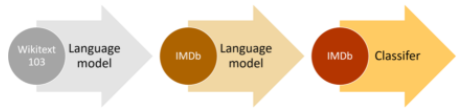

It takes quite a while to train each epoch, so we'll be saving the intermediate model results during the training process. Since fine_tune doesn't do that for us, we'll use fit_one_cycle. Just like cnn_learner, language_model_learner automatically calls freeze when using a pretrained model (which is the default), so this will only train the embeddings (the only part of the model that contains randomly initialized weights—i.e., embeddings for words that are in our IMDb vocab, but aren't in the pretrained model vocab):

In [38]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,8.227737,7.837894,0.066570,2534.861816,46:32


# Saving and Loading Models
You can easily save the state of your model like so:

In [39]:
learn.save('1epoch')

Path('C:/Users/Naim Cavin/.fastai/data/imdb/models/1epoch.pth')

This will create a file in learn.path/models/ named 1epoch.pth. If you want to load your model in another machine after creating your Learner the same way, or resume training later, you can load the content of this file with:

learn = learn.load('1epoch')


In [40]:
learn = learn.load('1epoch')

Once the initial training has completed, we can continue fine-tuning the model after unfreezing:



In [41]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.773357,4.670860,0.250352,106.789520,51:09


KeyboardInterrupt: 

Once this is done, we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. The model not including the final layer is called the encoder. We can save it with save_encoder

In [ ]:
learn.save_encoder('finetuned')

jargon: Encoder: The model not including the task-specific final layer(s). This term means much the same thing as body when applied to vision CNNs, but "encoder" tends to be more used for NLP and generative models.

# Creating the Classifier DataLoaders
We're now moving from language model fine-tuning to classifier fine-tuning. To recap, a language model predicts the next word of a document, so it doesn't need any external labels. A classifier, however, predicts some external label—in the case of IMDb, it's the sentiment of a document.

This means that the structure of our DataBlock for NLP classification will look very familiar. It's actually nearly the same as we've seen for the many image classification datasets we've worked with:

In [ ]:
dls_clas = DataBlock(
    blocks=(TextBlock.from_folder(path, vocab=dls_lm.vocab),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path, path=path, bs=128, seq_len=72)

In [ ]:
dls_clas.show_batch(max_n=3)


In [ ]:
nums_samp = toks200[:10].map(num)

In [ ]:
nums_samp.map(len)

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

In [ ]:
learn.fit_one_cycle(1, 2e-2)

The sorting and padding are automatically done by the data block API for us when using a TextBlock, with is_lm=False. (We don't have this same issue for language model data, since we concatenate all the documents together first, and then split them into equally sized sections.)

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()


The final step prior to training the classifier is to load the encoder from our fine-tuned language model. We use load_encoder instead of load because we only have pretrained weights available for the encoder; load by default raises an exception if an incomplete model is loaded:

In [ ]:
learn = learn.load_encoder('finetuned')